# Normalized Maximum mortality and confirmed Covid-19 cases rates from population density (linear regression).

In [127]:
""""
Created on Sat Mar 14 01:36:10 2020
@author: kuzn137
"""
import math
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
plt.style.use('seaborn-whitegrid')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
def model_Density(df, model):
    Ypr = []
    #take one sample out validation
    for i in df['density'].unique():
        X=df.loc[df['density']!=i, ['density']]
        Y=df.loc[df['density']!=i, ['max_rate']]
        model.fit(X,Y)
        X1 = df.loc[df['density']==i, ['density']]
        Ypr.append(model.predict(X1).tolist())
    ##remove [] 2 times
    Ypr = [i for sublist in Ypr for i in sublist]
    Ypr = [i for sublist in Ypr for i in sublist]
    df['pred']=np.array(Ypr)
    r2=1-sum(np.subtract(df['pred'],np.array(df['max_rate']))**2)/sum(np.subtract(df['max_rate'],df['max_rate'].mean())**2)
    error = np.divide(abs(np.subtract(Ypr,np.array(df['max_rate']))), np.array(df['max_rate'])).astype('float') 
    error= [i*i for i in error] 
    #print(np.subtract(df['pred'],df['max_rate'].mean()**2)
    #print(math.sqrt(sum(error)))
    error=math.sqrt(sum(error))/len(error)
   # err2=sum(r2)/len(r2)
    print("MSE")
    print(error)
    print('r2')
    print(r2)
    return Ypr, error

# Read data for confirmed cases, death and china population

In [128]:
vtime_d = pd.read_csv("time_series_covid_19_deaths.csv")#time series for confirmed cases
vtime_confirmed = pd.read_csv("time_series_covid_19_confirmed.csv")#time series for confirmed cases
popCN = pd.read_csv("CNPopulation.csv", encoding='ISO-8859-1')#china population
vtime_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,349,367,423,444,484,521,555,607,665,714
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,361,377,383,400,409,416,433,446,467,475
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1320,1423,1468,1572,1666,1761,1825,1914,1983,2070
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,501,525,545,564,583,601,601,638,646,659
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,14,16,17,19,19,19,19,19,19,19


In [129]:
popCN.head()

,Province/State,Population,density,age
0,Beijing,19621386,1167.40,80.18
1,Tianjin,12938224,1144.46,78.89
2,Hebei,71854202,382.81,74.97
3,Shanxi,35712111,228.48,74.92
4,Inner Mongolia,24706321,20.88,74.44


# Maximum mortality and disease confirmed cases rates

In [130]:
col_ex=['Country/Region', 'Lat', 'Long', 'Population', 'density', 'age']
col=[i for i in vtime_d.columns if i not in col_ex]
#dataframe for disease rate in china
dfCNrate_d=vtime_d.loc[(vtime_d['Country/Region'] == 'China'), col].set_index('Province/State').rolling(2, axis=1).apply(lambda x:x[1]-x[0]).fillna(0)
dfCNrate_confirmed=vtime_confirmed.loc[(vtime_confirmed['Country/Region']=='China'), col].set_index('Province/State').rolling(2, axis=1).apply(lambda x:x[1]-x[0]).fillna(0)
#dfCNrate=dfCNrate.iloc[:, 1:-18] #to remove dates with very low rate
#dfCNrate.head()

In [131]:
col = [i for i in dfCNrate_d.columns if i not in col_ex]
dfCNrate_d['max_rate'] = dfCNrate_d[col].max(axis=1)
dfCNrate_confirmed['max_rate'] = dfCNrate_confirmed[col].max(axis=1)
print(dfCNrate_d[dfCNrate_d['max_rate']==0])
dfCNrate_d=dfCNrate_d[dfCNrate_d['max_rate']>0]

                1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
Province/State                                                                  
Jiangsu             0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Macau               0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Ningxia             0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Qinghai             0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Shanxi              0.0      0.0      0.0      0.0      0.0      0.0      0.0   
Tibet               0.0      0.0      0.0      0.0      0.0      0.0      0.0   

                1/29/20  1/30/20  1/31/20  ...  4/6/20  4/7/20  4/8/20  \
Province/State                             ...                           
Jiangsu             0.0      0.0      0.0  ...     0.0     0.0     0.0   
Macau               0.0      0.0      0.0  ...     0.0     0.0     0.0   
Ningxia             0.0      0.0      0.0  ...     0.0 

# Merge with population information and normalize

In [132]:
#merge with china population table
dfCNrate_d=pd.merge(dfCNrate_d, popCN[['Province/State', 'Population', 'density', 'age']], on = 'Province/State', how='inner')
dfCNrate_confirmed=pd.merge(dfCNrate_confirmed, popCN[['Province/State', 'Population', 'density', 'age']], on = 'Province/State', how='inner')

#dfCNrate.head()

Maximum rate normalized by total population

In [133]:
dfCNrate_d['max_rate'] = dfCNrate_d['max_rate'].divide(dfCNrate_d['Population'])
#dfCNrate['age'] = dfCNrate['age'].subtract(dfCNrate['age'].mean())
dfCNrate_d=dfCNrate_d[dfCNrate_d['Province/State'] != 'Hubei'] # to exclude very high rate in Hubei
dfCNrate_confirmed['max_rate'] = dfCNrate_confirmed['max_rate'].divide(dfCNrate_confirmed['Population'])
#dfCNrate['age'] = dfCNrate['age'].subtract(dfCNrate['age'].mean())
dfCNrate_confirmed=dfCNrate_confirmed[dfCNrate_confirmed['Province/State'] != 'Hubei'] # to exclude very high rate in Hubei


# Linear regression model for mortality rate

In [134]:
model = lm.LinearRegression()#lm.Ridge(alpha=0.01)#
#Take one sample out validation
Ypr, error = model_Density(dfCNrate_d, model)

MSE
0.17178632350606707
r2
0.16158291897199828


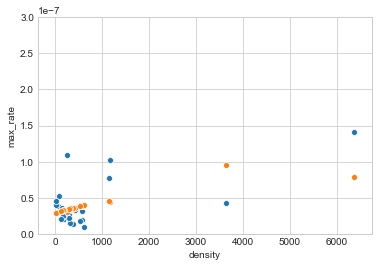

In [135]:
plt.figure()
plt.ylim(0, 0.0000003)
sns.scatterplot(dfCNrate_d['density'], dfCNrate_d['max_rate'])
sns.scatterplot(dfCNrate_d['density'], np.array(Ypr))

In [136]:
np.array([10194])

array([10194])

# Linear regression model for confirmed diseases cases

In [137]:
model = lm.LinearRegression()#lm.Ridge(alpha=0.01)#
#Take one sample out validation
Ypr, error = model_Density(dfCNrate_confirmed, model)

MSE
0.16409294220850104
r2
0.20074593257764073


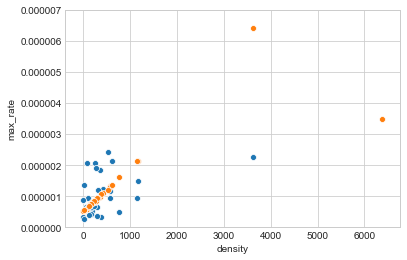

In [138]:
plt.figure()
plt.ylim(0, 0.000007)
sns.scatterplot(dfCNrate_confirmed['density'], dfCNrate_confirmed['max_rate'])
sns.scatterplot(dfCNrate_confirmed['density'], np.array(Ypr))